In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#hyper parameters config
batch_size = 200
transformer = transforms.Compose([
              transforms.Resize((180, 180)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       #First enhancement
])

# tensor will be shape ([200, 3, 180, 180])

In [4]:
train_path = './data/seg_train/seg_train'
test_path = './data/seg_test/seg_test'

In [5]:
import os

subfolders = [f.name for f in os.scandir(train_path) if f.is_dir()]

print(subfolders)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [6]:
train_loader = DataLoader(
    datasets.ImageFolder(train_path, transform = transformer),
    batch_size = batch_size, 
    shuffle = True
)

test_loader = DataLoader(
    datasets.ImageFolder(test_path, transform = transformer),
    batch_size = batch_size, 
    shuffle = True
) 

In [7]:
data_iter = iter(train_loader)
samples, labels = next(data_iter)
print(samples.shape)

torch.Size([200, 3, 180, 180])


In [8]:
class Net(nn.Module):
    def __init__(self, num_classes = 6):
        super().__init__()
        #input shape = [200, 3, 180, 180]
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 24, 
                               kernel_size = 3, 
                               stride = 1,
                               padding = 1)    #ensure spatial resolution remain the same.
        #shape = [200, 24, 180, 180]        
        self.relu1 = nn.ReLU()        
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2)
        #shape = [200, 24, 90, 90]
        
        self.conv2 = nn.Conv2d(in_channels = 24,
                               out_channels = 56,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1)
        
        #shape = [200, 56, 90, 90]
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2)
        #shape = [200, 56, 45, 45]
        
        #FC Layer
        self.fc = nn.Linear(in_features = 56 * 45 * 45, out_features = num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        #above output is in shape [200, 56, 45, 45]

        #Need to view as 1 column
        output = out.view(-1, 56*45*45)

        output = self.fc(output)

        return output

In [9]:
model = Net().to(device)

In [10]:
print(model)

Net(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=113400, out_features=6, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()  # automatically apply softmax function for us, so don't have to apply softmax on the last FC layer.
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [12]:
train_dataset = datasets.ImageFolder(train_path, transform=transformer)
train_count = len(train_dataset)

test_dataset = datasets.ImageFolder(test_path, transform=transformer)
test_count = len(test_dataset)

In [13]:
# Training loop
num_epochs = 5  # You can adjust the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, prediction = torch.max(outputs.data, 1)
        
        train_accuracy += int(torch.sum(prediction==labels.data))
    
    train_accuracy = train_accuracy / train_count
        
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader)}, Accuracy: {train_accuracy * 100:.2f}%")

Epoch [1/5] - Loss: 1.9445768905357577, Accuracy: 47.15%
Epoch [2/5] - Loss: 0.8447386580453792, Accuracy: 68.90%
Epoch [3/5] - Loss: 0.7048781044046644, Accuracy: 74.78%
Epoch [4/5] - Loss: 0.611798063969948, Accuracy: 78.15%
Epoch [5/5] - Loss: 0.49008782564754216, Accuracy: 83.05%


In [14]:
# Test Loop

model.eval()  # Set the model to evaluation mode
total = 0
correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")

Accuracy on the test dataset: 73.87%


In [15]:
# saving model

torch.save(model.state_dict(), 'trained_model.pth')

In [16]:
# test model on single image.

model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

from PIL import Image

image = Image.open('./data/seg_pred/seg_pred/3.jpg')

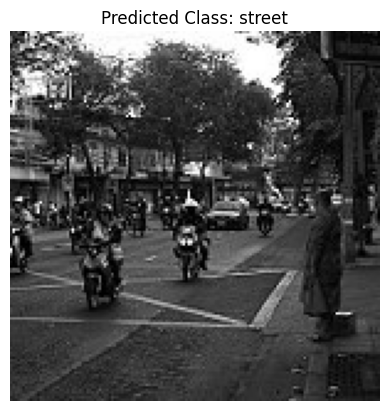

In [17]:
# Apply same transformation to image during training.
input_tensor = transformer(image).unsqueeze(0)  # Add a batch dimension

# Move data to the GPU if available
input_tensor = input_tensor.to(device) 

output = model(input_tensor)
_, predicted = torch.max(output, 1)

# Display the image and predicted class
# Example: Show the image using matplotlib
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f"Predicted Class: {subfolders[predicted.item()]}")
plt.axis('off')
plt.show()

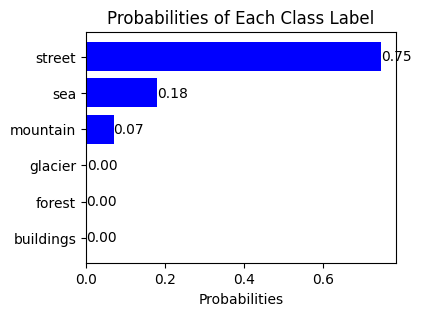

In [37]:
with torch.no_grad():
    probabilities = torch.softmax(output, axis = 1)

probabilities = probabilities.cpu().detach().numpy().flatten()
data = list(zip(subfolders, probabilities))
data.sort(key=lambda x: x[1], reverse=False)
sorted_class_labels, sorted_probabilities = zip(*data)

plt.figure(figsize=(4, 3))
bars = plt.barh(subfolders, sorted_probabilities, color='blue')
plt.xlabel('Probabilities')
plt.title('Probabilities of Each Class Label')

for bar, prob in zip(bars, sorted_probabilities):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{prob:.2f}', va='center')

plt.show()